In [3]:
using Pkg
Pkg.add("CUDNN_jll")

   Resolving package versions...
  No Changes to `C:\Users\drobi\Desktop\uni\master_thesis\CounterfactualExplanations.jl\dev\notebooks\Project.toml`
  No Changes to `C:\Users\drobi\Desktop\uni\master_thesis\CounterfactualExplanations.jl\dev\notebooks\Manifest.toml`


In [4]:
using DataFrames
using Transformers
using Transformers.TextEncoders
using Transformers.HuggingFace
using TrillionDollarWords
using StatsBase
using Flux

### Load data

In [5]:
n = 10
data = load_training_sentences()
texts = filter(:split => n -> n == "test", data)[1:n, :]

Row,sentence,year,label,seed,sentence_splitting,event_type,split
,String,Int64,String7,Int64,Bool,String31,String7
1,"remained well below their levels at the beginning of the year, and that weaker demand and earlier declines in oil prices had been holding down consumer price inflation.",1996,hawkish,5768,true,meeting minutes,test
2,"A few participants also noted that uncertainty about the extent of resource slack in the economy was considerable and that it was quite possible that the economy could soon be operating close to potential, particularly if labor force participation rates did not turn up much while employment continued to register gains.",1996,neutral,5768,true,meeting minutes,test
3,inflation was projected to pick up gradually in association with a partial reversal of the decline in energy prices this year.,1996,neutral,5768,true,meeting minutes,test
4,They noted that the realization of such a development could make it harder for the Committee to achieve 2 percent inflation over the longer run.,1996,neutral,5768,true,meeting minutes,test
5,"In the view of one member, however, aggregate final demand was so strong that, with economic activity and the associated demand for labor having expanded at an unsustainable pace for some time, one could be reasonably confident that inflation would most likely pick up in the absence of policy action.",1996,hawkish,5768,true,meeting minutes,test
6,"In the circumstances, most members endorsed a proposal to delete as no longer necessary the previous summary statement relating to the risks to growth and inflation taken together.",1996,neutral,5768,true,meeting minutes,test
7,"In the staff forecast prepared for this meeting, the economy was seen as likely to expand at a moderate pace, supported by accommodative monetary policy and financial conditions.",1996,dovish,5768,true,meeting minutes,test
8,"Housing starts and the demand for new homes had declined further, house prices in many parts of the country were falling faster than they had towards the end of 2007, and inventories of unsold homes remained quite elevated.",1996,dovish,5768,true,meeting minutes,test
9,Pressures on resources would rise as the anticipated upturn and possible above-trend growth brought the economy closer to full capacity utilization.,1996,hawkish,5768,true,meeting minutes,test


### Get attributions

In [1]:
using CondaPkg
CondaPkg.add("pytorch")
CondaPkg.add("transformers"; version="4.15.0")
CondaPkg.add("transformers-interpret")
CondaPkg.add("cuDNN")

    CondaPkg Found dependencies: C:\Users\drobi\Desktop\uni\master_thesis\CounterfactualExplanations.jl\dev\notebooks\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\drobi\.julia\packages\PythonCall\wXfah\CondaPkg.toml
    CondaPkg Dependencies already up to date
    CondaPkg Found dependencies: C:\Users\drobi\Desktop\uni\master_thesis\CounterfactualExplanations.jl\dev\notebooks\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\drobi\.julia\packages\PythonCall\wXfah\CondaPkg.toml
    CondaPkg Dependencies already up to date
    CondaPkg Found dependencies: C:\Users\drobi\Desktop\uni\master_thesis\CounterfactualExplanations.jl\dev\notebooks\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\drobi\.julia\packages\PythonCall\wXfah\CondaPkg.toml
    CondaPkg Dependencies already up to date
    CondaPkg Found dependencies: C:\Users\drobi\Desktop\uni\master_thesis\CounterfactualExplanations.jl\dev\notebooks\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\drobi\.jul

In [2]:
using PythonCall

transformers_interpret = PythonCall.pyimport("transformers_interpret")
transformers = PythonCall.pyimport("transformers")

# load pre-trained classifier and corresponding tokenizer
model = transformers.RobertaForSequenceClassification.from_pretrained("model", local_files_only=true)
tokenizer = transformers.AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa")

scorer = transformers_interpret.SequenceClassificationExplainer(model, tokenizer, attribution_type="lig")

Python: <transformers_interpret.explainers.sequence_classification.SequenceClassificationExplainer object at 0x00000263DA9A8070>

In [6]:
function get_attributions(text, scorer)
    attribs = scorer(text, index=0, internal_batch_size=1)
    attributions = pyconvert(Array{Tuple{String, Float64}}, attribs)
    return attributions
end

get_attributions (generic function with 1 method)

In [7]:
attributions = get_attributions(texts[1, :].sentence, scorer)

34-element Vector{Tuple{String, Float64}}:
 ("<s>", 0.0)
 ("rem", -0.09617849663936606)
 ("ained", -0.29702715615956665)
 ("well", 0.25551209840018674)
 ("below", -0.4015987185377847)
 ("their", -0.013975036770146217)
 ("levels", -0.13794157805498133)
 ("at", -0.002103001077563767)
 ("the", 0.14926277592717438)
 ("beginning", 0.08228264530334284)
 ("of", 0.08006335674570937)
 ("the", 0.24284418735078794)
 ("year", 0.20003154332566433)
 ⋮
 ("oil", -0.06976564966318043)
 ("prices", 0.011989646035101107)
 ("had", -0.15355389676950998)
 ("been", -0.10492307025848874)
 ("holding", -0.07771222018418246)
 ("down", -0.024919108109520634)
 ("consumer", 0.09788758630638592)
 ("price", 0.011979387105458176)
 ("inflation", -0.09257150340664654)
 (".", 0.15492799445950947)
 ("", -0.3214473479860127)
 ("</s>", 0.0)

### Mask the word attributions

In [8]:
cls = TrillionDollarWords.load_model(; output_hidden_states=true)

┌ Warning: fuse_unk is unsupported, the tokenization result might be slightly different in some cases.
└ @ Transformers.HuggingFace C:\Users\drobi\.julia\packages\Transformers\lD5nW\src\huggingface\tokenizer\utils.jl:42
┌ Warning: match token `<mask>` require to match with space on either side but that is not implemented here, the tokenization result might be slightly different in some cases.
└ @ Transformers.HuggingFace C:\Users\drobi\.julia\packages\Transformers\lD5nW\src\huggingface\tokenizer\utils.jl:42


BaselineModel(GPT2TextEncoder(
├─ TextTokenizer(MatchTokenization(CodeNormalizer(BPETokenization(GPT2Tokenization, bpe = CachedBPE(BPE(50000 merges))), codemap = CodeMap{UInt8 => UInt16}(3 code-ranges)), 5 patterns)),
├─ vocab = Vocab{String, SizedArray}(size = 50265, unk = <unk>, unki = 4),
├─ codemap = CodeMap{UInt8 => UInt16}(3 code-ranges),
├─ startsym = <s>,
├─ endsym = </s>,
├─ padsym = <pad>,
├─ trunc = 256,
└─ process = Pipelines:
  ╰─ target[token] := TextEncodeBase.nestedcall(string_getvalue, source)
  ╰─ target[token] := Transformers.TextEncoders.grouping_sentence(target.token)
  ╰─ target[(token, segment)] := SequenceTemplate{String}(<s>:<type=1> Input:<type=1> </s>:<type=1> (</s>:<type=1> Input:<type=1> </s>:<type=1>)...)(target.token)
  ╰─ target[attention_mask] := (NeuralAttentionlib.LengthMask ∘ Transformers.TextEncoders.getlengths(256))(target.token)
  ╰─ target[token] := TextEncodeBase.trunc_or_pad(256, <pad>, tail, tail)(target.token)
  ╰─ target[token] := TextEncode

In [9]:
function group_into_words(text, attributions, cls_tkr)
    toks = decode(cls_tkr, encode(cls_tkr, text).token)
    word_attributions = []
    for (i, (dec_tok, attrib)) in enumerate(zip(toks, attributions))
        if startswith(dec_tok, "<")
            continue
        elseif length(word_attributions) == 0 || startswith(dec_tok, " ")
            push!(word_attributions, ([i], [attrib[1]], [attrib[2]]))
        else 
            last_processed = last(word_attributions)
            push!(last_processed[1], i)
            push!(last_processed[2], attrib[1])
            push!(last_processed[3], attrib[2])
        end
    end
    return word_attributions
end

group_into_words (generic function with 1 method)

In [10]:
text = texts[1, :].sentence
word_attributions = group_into_words(text, attributions, cls.tkr)

28-element Vector{Any}:
 ([2, 3], ["rem", "ained"], [-0.09617849663936606, -0.29702715615956665])
 ([4], ["well"], [0.25551209840018674])
 ([5], ["below"], [-0.4015987185377847])
 ([6], ["their"], [-0.013975036770146217])
 ([7], ["levels"], [-0.13794157805498133])
 ([8], ["at"], [-0.002103001077563767])
 ([9], ["the"], [0.14926277592717438])
 ([10], ["beginning"], [0.08228264530334284])
 ([11], ["of"], [0.08006335674570937])
 ([12], ["the"], [0.24284418735078794])
 ([13, 14], ["year", ","], [0.20003154332566433, 0.13104142887853437])
 ([15], ["and"], [0.17795123590947837])
 ([16], ["that"], [0.177958452206897])
 ⋮
 ([20], ["earlier"], [-0.2643532357406369])
 ([21], ["declines"], [0.14990056209456956])
 ([22], ["in"], [-0.3258371366392156])
 ([23], ["oil"], [-0.06976564966318043])
 ([24], ["prices"], [0.011989646035101107])
 ([25], ["had"], [-0.15355389676950998])
 ([26], ["been"], [-0.10492307025848874])
 ([27], ["holding"], [-0.07771222018418246])
 ([28], ["down"], [-0.024919108109520

In [11]:
function get_top_k_idx(attributions, k=10)
    sorted = sort(attributions, by = x -> -maximum(x[3]))
    idx_to_mask = []
    for row in first(sorted, k)
        append!(idx_to_mask, row[1])
    end
    return idx_to_mask
end

get_top_k_idx (generic function with 2 methods)

In [12]:
idx_to_mask = get_top_k_idx(word_attributions)

12-element Vector{Any}:
  4
 12
 19
 13
 14
 16
 15
 31
 32
 21
  9
 29

In [13]:
function mask_toks_at_idx(toks, idx_to_mask)
    masked_text = Vector{Char}()
    for (i, token) in enumerate(toks)
        if startswith(token, "<")
            continue
        elseif i in idx_to_mask
            append!(masked_text, " [MASK]")
        else
            append!(masked_text, token)
        end
    end
    
    return String(masked_text)
end

mask_toks_at_idx (generic function with 1 method)

In [32]:
toks = decode(cls.tkr, encode(cls.tkr, text).token)
masked_text = mask_toks_at_idx(toks, idx_to_mask)

"remained [MASK] below their levels at [MASK] beginning of [MASK] [MASK] [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK]"

In [15]:
function load_model(; kwrgs...)
    model_name = "karoldobiczek/relitc-FOMC-CMLM"
    tkr = Transformers.load_tokenizer(model_name)
    cfg = Transformers.HuggingFace.HGFConfig(Transformers.load_config(model_name); kwrgs...)
    mod = Transformers.load_model(model_name, "ForMaskedLM"; config = cfg)

    return tkr, mod, cfg
end
cmlm_tkr, cmlm_model = load_model()

(BertTextEncoder(
├─ TextTokenizer(MatchTokenization(WordPieceTokenization(bert_uncased_tokenizer, WordPiece(vocab_size = 30522, unk = [UNK], max_char = 100)), 5 patterns)),
├─ vocab = Vocab{String, SizedArray}(size = 30522, unk = [UNK], unki = 101),
├─ startsym = [CLS],
├─ endsym = [SEP],
├─ padsym = [PAD],
├─ trunc = 512,
└─ process = Pipelines:
  ╰─ target[token] := TextEncodeBase.nestedcall(string_getvalue, source)
  ╰─ target[token] := Transformers.TextEncoders.grouping_sentence(target.token)
  ╰─ target[(token, segment)] := SequenceTemplate{String}([CLS]:<type=1> Input[1]:<type=1> [SEP]:<type=1> (Input[2]:<type=2> [SEP]:<type=2>)...)(target.token)
  ╰─ target[attention_mask] := (NeuralAttentionlib.LengthMask ∘ Transformers.TextEncoders.getlengths(512))(target.token)
  ╰─ target[token] := TextEncodeBase.trunc_and_pad(512, [PAD], head, tail)(target.token)
  ╰─ target[token] := TextEncodeBase.nested2batch(target.token)
  ╰─ target[segment] := TextEncodeBase.trunc_and_pad(512, 1, hea

In [33]:
cmlm_decoded = decode(cmlm_tkr, encode(cmlm_tkr, masked_text).token)

32-element Vector{String}:
 "[CLS]"
 "remained"
 "[MASK]"
 "below"
 "their"
 "levels"
 "at"
 "[MASK]"
 "beginning"
 "of"
 "[MASK]"
 "[MASK]"
 "[MASK]"
 ⋮
 "in"
 "oil"
 "prices"
 "had"
 "been"
 "holding"
 "down"
 "[MASK]"
 "price"
 "[MASK]"
 "[MASK]"
 "[SEP]"

In [34]:
function get_idx_cmlm(cmlm_decoded)
    idx_to_mask = []
    for (i, tok) in enumerate(cmlm_decoded)
        if tok == "[MASK]"
            push!(idx_to_mask, i)
        end
    end
    return idx_to_mask
end

get_idx_cmlm (generic function with 1 method)

In [178]:
idx_to_mask = get_idx_cmlm(cmlm_decoded)

12-element Vector{Any}:
  3
  8
 11
 12
 13
 14
 15
 18
 20
 28
 30
 31

### Fill in masks

In [36]:
function merge_tokens(tokens, idx_to_mask=[])
    merged_text = Vector{Char}()
    for (i, token) in enumerate(tokens)
        if i in idx_to_mask
            append!(merged_text, " [MASK]")
        else
            append!(merged_text, " " * token)
        end
    end
    
    return chop(String(merged_text), head=1, tail=0)
end

merge_tokens (generic function with 2 methods)

In [37]:
function group_into_words(cmlm_out, delim="##")
    word_list = []
    for token in cmlm_out
        if startswith(delim, token) && length(word_list) != 0
            last(word_list) = last(word_list) * chop(token, head=2, tail=0)
        else 
            push(word_list, token)
        end
    end
    return word_list
end

group_into_words (generic function with 3 methods)

In [122]:
function left_to_right_filling(tokens, mask_positions, model, tokenizer)
    if length(mask_positions) == 0
        return merge_tokens(tokens)
    end

    masked_text = merge_tokens(tokens, mask_positions)
    # println(masked_text)
    
    out = decode(cmlm_tkr, cmlm_model(encode(cmlm_tkr, masked_text)).logit)
    
    mask_positions = sort(mask_positions)
    next_position = popfirst!(mask_positions)

    next_token = out[next_position+1]

    tokens[next_position] = next_token

    return left_to_right_filling(tokens, mask_positions, model, tokenizer)
end

left_to_right_filling (generic function with 1 method)

In [39]:
left_to_right_filling(copy(cmlm_decoded), idx_to_mask, cmlm_model, cmlm_tkr)

[CLS] remained [MASK] below their levels at [MASK] beginning of [MASK] [MASK] [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK] [SEP]
[CLS] remained well below their levels at [MASK] beginning of [MASK] [MASK] [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK] [SEP]
[CLS] remained well below their levels at the beginning of [MASK] [MASK] [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK] [SEP]
[CLS] remained well below their levels at the beginning of august [MASK] [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK] [SEP]
[CLS] remained well below their levels at the beginning of august to [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK] [SEP]
[

"[CLS] remained well below their levels at the beginning of august to alleviate concerns about weaker demand as earlier increases in oil prices had been holding down consumer price expectations . [SEP]"

In [176]:
function uncertainty_filling(tokens, mask_positions, model, tokenizer)
    if length(mask_positions) == 0
        return merge_tokens(tokens)
    end

    masked_text = merge_tokens(tokens, mask_positions)
    # println(masked_text)

    logits = cmlm_model(encode(cmlm_tkr, masked_text)).logit
    out = decode(cmlm_tkr, logits)

    probs = softmax(logits[:, mask_positions, :], dims=1)
    
    entrs = []
    for i in 1:length(mask_positions)
        push!(entrs, entropy(probs[:, i]))
    end
    
    next_position = mask_positions[argmin(entrs)]
    filter!(x -> x != next_position, mask_positions)
    
    next_token = out[next_position+1]

    tokens[next_position] = next_token
    return uncertainty_filling(tokens, mask_positions, model, tokenizer)
end

uncertainty_filling (generic function with 1 method)

In [179]:
uncertainty_filling(copy(cmlm_decoded), idx_to_mask, cmlm_model, cmlm_tkr)

"[CLS] remained well below their levels at the beginning of august to help alleviate the weaker demand that earlier gains in oil prices had been holding down on price stability . [SEP]"

In [42]:
function merge_truncated_words(tokens, in_word="##", between_word="", separators=[".", "de"])
    decoded = Vector{Char}()
    for token in tokens
        token = string(token)
        if token in separators
            continue
        else
            if startswith(token, in_word)
                if length(decoded) == 0
                    append!(decoded, token)
                else
                    last = pop!(decoded)
                    new_token = last * chop(token, head=2, tail=0)
                    append!(decoded, new_token)
                end
            else
                append!(decoded, " " * token)
            end
        end
    end
    return decoded
end

merge_truncated_words (generic function with 4 methods)

In [44]:
n = 10
data = load_training_sentences()
texts = filter(:split => n -> n == "test", data)[1:n, :]

Row,sentence,year,label,seed,sentence_splitting,event_type,split
,String,Int64,String7,Int64,Bool,String31,String7
1,"remained well below their levels at the beginning of the year, and that weaker demand and earlier declines in oil prices had been holding down consumer price inflation.",1996,hawkish,5768,true,meeting minutes,test
2,"A few participants also noted that uncertainty about the extent of resource slack in the economy was considerable and that it was quite possible that the economy could soon be operating close to potential, particularly if labor force participation rates did not turn up much while employment continued to register gains.",1996,neutral,5768,true,meeting minutes,test
3,inflation was projected to pick up gradually in association with a partial reversal of the decline in energy prices this year.,1996,neutral,5768,true,meeting minutes,test
4,They noted that the realization of such a development could make it harder for the Committee to achieve 2 percent inflation over the longer run.,1996,neutral,5768,true,meeting minutes,test
5,"In the view of one member, however, aggregate final demand was so strong that, with economic activity and the associated demand for labor having expanded at an unsustainable pace for some time, one could be reasonably confident that inflation would most likely pick up in the absence of policy action.",1996,hawkish,5768,true,meeting minutes,test
6,"In the circumstances, most members endorsed a proposal to delete as no longer necessary the previous summary statement relating to the risks to growth and inflation taken together.",1996,neutral,5768,true,meeting minutes,test
7,"In the staff forecast prepared for this meeting, the economy was seen as likely to expand at a moderate pace, supported by accommodative monetary policy and financial conditions.",1996,dovish,5768,true,meeting minutes,test
8,"Housing starts and the demand for new homes had declined further, house prices in many parts of the country were falling faster than they had towards the end of 2007, and inventories of unsold homes remained quite elevated.",1996,dovish,5768,true,meeting minutes,test
9,Pressures on resources would rise as the anticipated upturn and possible above-trend growth brought the economy closer to full capacity utilization.,1996,hawkish,5768,true,meeting minutes,test


In [45]:
cmlm_tkr, cmlm_model = load_model()
cls = TrillionDollarWords.load_model(; output_hidden_states=true)

using PythonCall

transformers_interpret = PythonCall.pyimport("transformers_interpret")
transformers = PythonCall.pyimport("transformers")

# load pre-trained classifier and corresponding tokenizer
model = transformers.RobertaForSequenceClassification.from_pretrained("model", local_files_only=true)
tokenizer = transformers.AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa")

scorer = transformers_interpret.SequenceClassificationExplainer(model, tokenizer, attribution_type="lig")

┌ Warning: fuse_unk is unsupported, the tokenization result might be slightly different in some cases.
└ @ Transformers.HuggingFace C:\Users\drobi\.julia\packages\Transformers\lD5nW\src\huggingface\tokenizer\utils.jl:42
┌ Warning: match token `<mask>` require to match with space on either side but that is not implemented here, the tokenization result might be slightly different in some cases.
└ @ Transformers.HuggingFace C:\Users\drobi\.julia\packages\Transformers\lD5nW\src\huggingface\tokenizer\utils.jl:42


Python: <transformers_interpret.explainers.sequence_classification.SequenceClassificationExplainer object at 0x00000263E1138910>

In [46]:
attributions = get_attributions(texts[1, :].sentence, scorer)

text = texts[1, :].sentence
word_attributions = group_into_words(text, attributions, cls.tkr)
idx_to_mask = get_top_k_idx(word_attributions)

toks = decode(cls.tkr, encode(cls.tkr, text).token)
mask_toks_at_idx(toks, idx_to_mask)

cmlm_decoded = decode(cmlm_tkr, encode(cmlm_tkr, masked_text).token)

idx_to_mask = get_idx_cmlm(cmlm_decoded)

left_to_right_filling(copy(cmlm_decoded), idx_to_mask, cmlm_model, cmlm_tkr)

[CLS] remained [MASK] below their levels at [MASK] beginning of [MASK] [MASK] [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK] [SEP]
[CLS] remained well below their levels at [MASK] beginning of [MASK] [MASK] [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK] [SEP]
[CLS] remained well below their levels at the beginning of [MASK] [MASK] [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK] [SEP]
[CLS] remained well below their levels at the beginning of august [MASK] [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK] [SEP]
[CLS] remained well below their levels at the beginning of august to [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK] [SEP]
[

"[CLS] remained well below their levels at the beginning of august to alleviate concerns about weaker demand as earlier increases in oil prices had been holding down consumer price expectations . [SEP]"

In [107]:
using Plots

In [52]:
entropy([.2, .3, .5, .1])

1.2599115233639782

In [90]:
enc = encode(cmlm_tkr, "remained [MASK] below their levels at [MASK] beginning of [MASK] [MASK] [MASK] [MASK] [MASK] weaker demand [MASK] earlier [MASK] in oil prices had been holding down [MASK] price [MASK] [MASK]")
out = cmlm_model(enc)
colors = []
masks = []
for i in 1:size(enc.token)[2]
    if argmax(enc.token[:, i, :])[1] == 104
        push!(masks, i)
        push!(colors, :red)
    else
        push!(colors, :blue)
    end
end

In [126]:
entropies = []
toks = []

probs = softmax(out.logit, dims=1)

for i in 1:size(out.logit)[2]
    row = out.logit[:, i, :]
    tok = decode(cmlm_tkr, row)
    push!(toks, tok)
    entr = entropy(probs[:, i])
    push!(entropies, entr)
    if i in masks
        println(string(tok) * " " * string(entr))
    end
end

["well"] 0.8925405
["the"] 0.001739249
["august"] 2.5585306
["quarter"] 4.2470326
["to"] 5.439382
["to"] 5.78602
["of"] 4.4509435
["and"] 2.307382
["increases"] 2.3528287
["the"] 4.842994
["stability"] 2.4602342
["."] 2.0014744


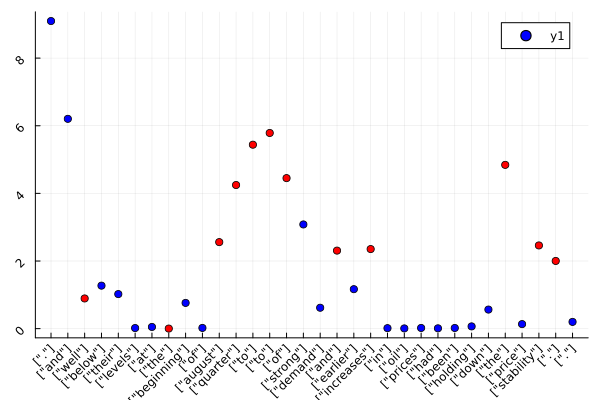

In [127]:
masked_toks = toks
# entr = -log.(-entropies[masks])
scatter(entropies, markercolor=colors, xticks = (1:size(masked_toks)[1], masked_toks), rot=45)

In [154]:
[1, 2, 3][~[2]]

LoadError: MethodError: no method matching ~(::Vector{Int64})

[0mClosest candidates are:
[0m  ~([91m::TimeZones.Class[39m)
[0m[90m   @[39m [32mTimeZones[39m [90mC:\Users\drobi\.julia\packages\TimeZones\F3BhS\src\[39m[90m[4mclass.jl:52[24m[39m
[0m  ~([91m::Py[39m)
[0m[90m   @[39m [32mPythonCall[39m [90mC:\Users\drobi\.julia\packages\PythonCall\wXfah\src\[39m[90m[4mPy.jl:379[24m[39m
[0m  ~([91m::Missing[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:101[24m[39m
[0m  ...
